# Wind Turbine Energy Prediction Model
### Objective
Created an energy model using a multiple linear regression function, Random forest regressor and XGB regresson function to predict the energy generation of a wind turbine based on 2018 Scada Data of a Wind Turbine in Turkey.
Visualise the dataset and results.
Compare between these three models.


### About Dataset
#### Context: 
In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.
#### Content:
The data's in the file are:
- Date/Time (for 10 minutes intervals).

- LV ActivePower (kW): The power generated by the turbine for that moment.

- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use    for electricity generation).

- Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer.

- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly).


## 1. Import the relevant libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Libraries Imported...Go Ahead!!")

Libraries Imported...Go Ahead!!


## 2. Load the data

In [2]:
mydata = pd.read_csv("T1.csv")

#renaming the column name
mydata.rename(columns={'Theoretical_Power_Curve (KWh)': 'Theoretical Power Curve (KWh)'}, inplace=True)

mydata.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical Power Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
print(mydata.describe())
print(mydata.info())

       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical Power Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589  
<class 'pandas.core.frame.DataFrame'

## 3. Preparing the data

In [4]:
# removing negative or zero LV Active Power from data
mydata = mydata[mydata['LV ActivePower (kW)'] > 0]

mydata2= mydata.copy()

# Convert Date/Time to datetime format
mydata['Date/Time'] = pd.to_datetime(mydata['Date/Time'])
mydata['YEAR'] = mydata['Date/Time'].dt.year
mydata['MONTH'] = mydata['Date/Time'].dt.month
mydata['DAY'] = mydata['Date/Time'].dt.day
mydata['hour'] = mydata['Date/Time'].dt.hour
mydata = mydata.drop(['Date/Time'], axis=1)

# Adding the column loss, loss= theoretical power - active power
mydata['Loss (kW)'] = mydata['Theoretical Power Curve (KWh)'] -mydata['LV ActivePower (kW)']

#remove missing values using dropna() function
mydata.dropna()

print(mydata.describe())

       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical Power Curve (KWh)  \
count         39692.000000      39692.000000                   39692.000000   
mean           1664.751281          8.769781                    1829.739672   
std            1264.303861          3.773594                    1306.418817   
min               0.000200          1.208934                       0.000000   
25%             481.681473          5.911951                     595.684321   
50%            1394.047974          8.114283                    1596.105035   
75%            2908.239746         11.099597                    3306.484805   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)     YEAR         MONTH           DAY          hour  \
count        39692.000000  39692.0  39692.000000  39692.000000  39692.000000   
mean           115.532274   2018.0      6.611231     15.604127     11.693339   
std             86.276846      0.0      3.341150

## 4. Visualising the mydata

#### Creating a pair plot of between all the column to identify correlations.

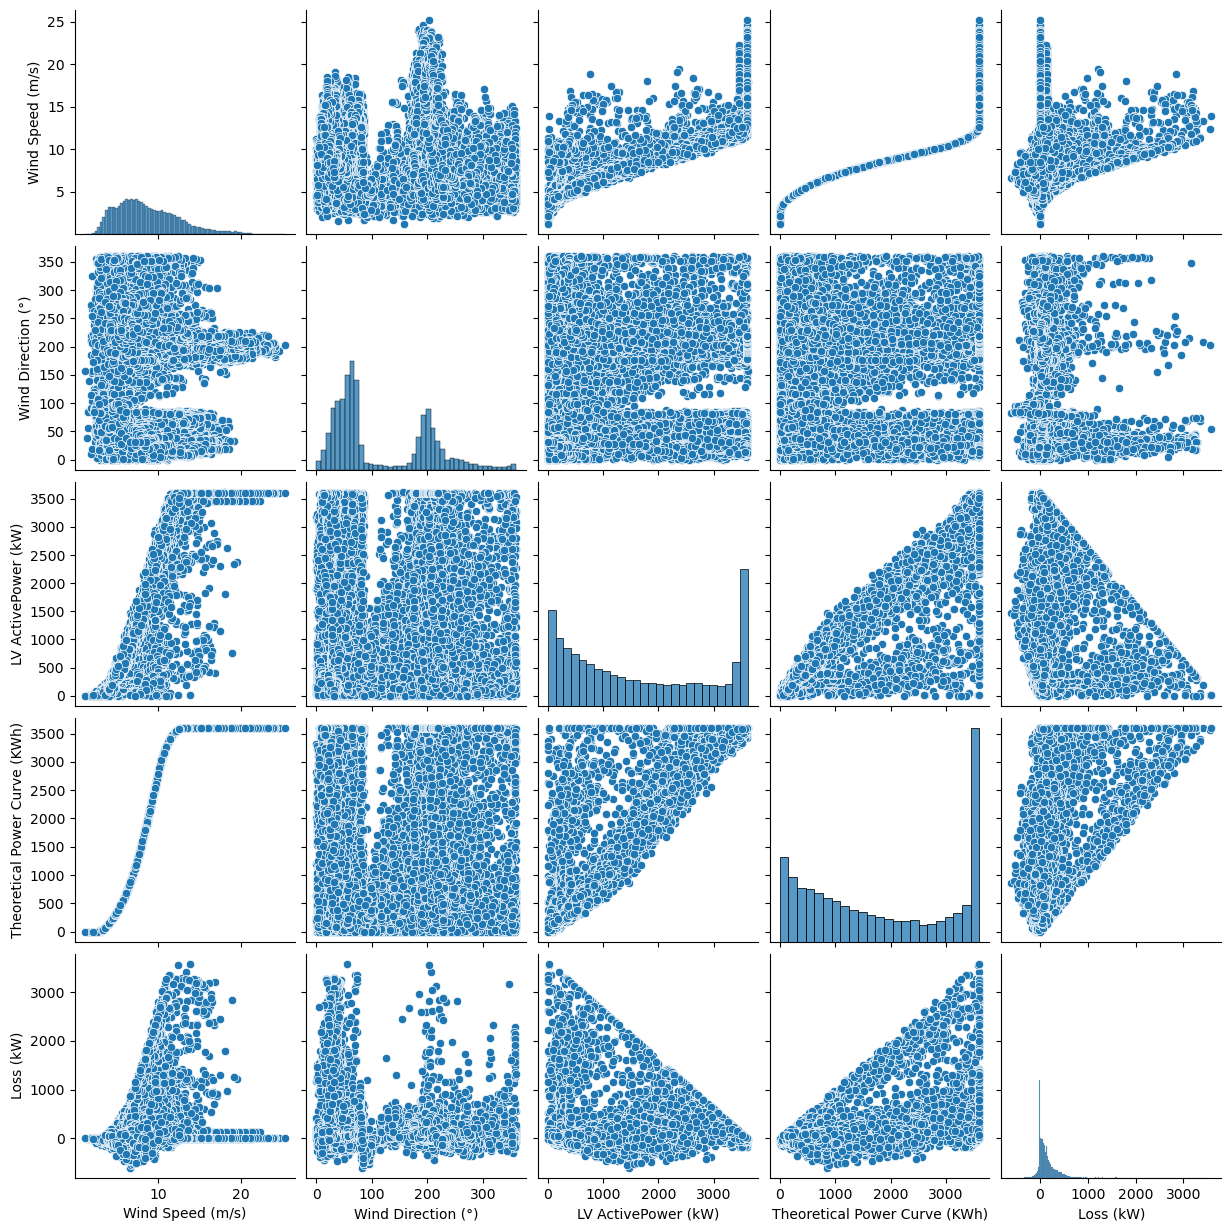

In [5]:
sns.pairplot(data=mydata, vars=["Wind Speed (m/s)", "Wind Direction (°)", "LV ActivePower (kW)", "Theoretical Power Curve (KWh)","Loss (kW)"])
plt.show()

Evident correlation can be made from above plots.

#### Creating a Box plot of LV ActivePower by month.

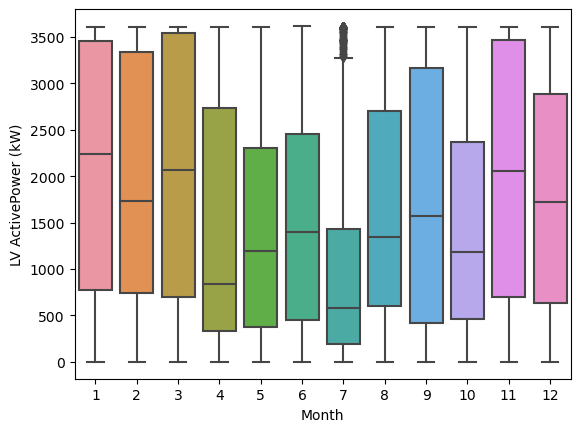

In [6]:
X=mydata['MONTH']
sns.boxplot(x=X, y=mydata['LV ActivePower (kW)'])
plt.xlabel("Month")
plt.ylabel("LV ActivePower (kW)")
plt.show()

Observations: We can see that the widest rangest of active power are for the months of January, February, March,September, November, and December. This must align with the a higher wind speed compared to other months during the course of the year.

## 5.Splitting the data into training and test sets:

In [7]:
# defining the desired features(input) as X to use for prediction: wind speed, wind direction, and 
# theoretical power curve and the target variable as y, which is the LV ActivePower (kW).

X = mydata[['Wind Speed (m/s)', 'Wind Direction (°)','MONTH','DAY','hour']]
y = mydata['LV ActivePower (kW)']

# splitting the data train_test_split() function from the sklearn.model_selection module:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# random_state=0 is an optional parameter that sets the random seed for reproducibility.


## 6. Linear Regression Model

### 6.1 Training and testing the model

In [8]:
# Building the model:

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluating the model, calculating metrics:

y1_pred = linear_model.predict(X_test)
y1_mse = mean_squared_error(y_test, y1_pred)
y1_mae = mean_absolute_error(y_test, y1_pred)
y1_r2 = r2_score(y_test, y1_pred)

print("Coefficients:", linear_model.coef_) #coefficient of all the features
print("Intercept:", linear_model.intercept_)
print("Mean Squared Error:", y1_mse)
print("Mean Absolute Error:", y1_mae)
print("R-squared:", y1_r2)
Accuracy_LR = 100*y1_r2
print('Accuracy of Linear Regression Model: ',Accuracy_LR)

Coefficients: [313.64373749  -0.38680755  10.42226576   0.59346052   2.55657314]
Intercept: -1146.9260299745606
Mean Squared Error: 227817.66988870103
Mean Absolute Error: 334.26589942969554
R-squared: 0.8559667280370811
Accuracy of Linear Regression Model:  85.5966728037081


### 6.2 Visualizing the model
Visualizing the model's performance by comparing the actual output with the predicted output on the test set using a scatter plot.



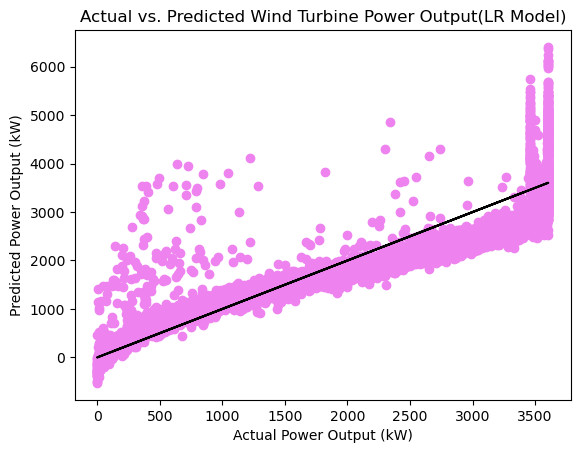

In [9]:
plt.scatter(y_test, y1_pred, color='violet')

# Adding a line representing perfect predictions (i.e., y_test = y1_pred)
plt.plot(y_test, y_test, color='black')

plt.xlabel("Actual Power Output (kW)")
plt.ylabel("Predicted Power Output (kW)")
plt.title("Actual vs. Predicted Wind Turbine Power Output(LR Model)")

plt.show()

## 7. Random Forest Regressor Model


### 7.1 Training and testing the model

In [10]:
# Building the model:

forest_model = RandomForestRegressor(n_estimators=100, max_depth=10)
forest_model.fit(X_train, y_train)

# Evaluating the model, calculating metrics:

y2_pred = forest_model.predict(X_test)
y2_mse = mean_squared_error(y_test, y2_pred)
y2_mae = mean_absolute_error(y_test, y2_pred)
y2_r2 = r2_score(y_test, y2_pred)

print("Mean Squared Error:", y2_mse)
print("Mean Absolute Error:", y2_mae)
print("R-squared:", y2_r2)
Accuracy_RF = 100*y2_r2
print('Accuracy of Random Forest Regressor Model: ',Accuracy_RF)

Mean Squared Error: 30224.202814289532
Mean Absolute Error: 87.23240098489472
R-squared: 0.9808913381216665
Accuracy of Random Forest Regressor Model:  98.08913381216665


### 7.2 Visualizing the model


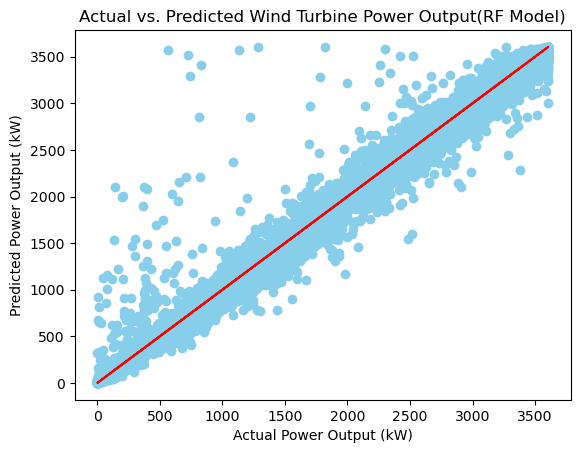

In [11]:
plt.scatter(y_test, y2_pred, color='skyblue')

# Adding a line representing perfect predictions (i.e., y_test = y2_pred)
plt.plot(y_test, y_test, color='red')

plt.xlabel("Actual Power Output (kW)")
plt.ylabel("Predicted Power Output (kW)")
plt.title("Actual vs. Predicted Wind Turbine Power Output(RF Model)")

plt.show()

## 8. XGBoost Model

### 8.1 Training and testing the model

In [12]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [13]:
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

y3_pred = xgb_model.predict(X_test)
y3_mse = mean_squared_error(y_test, y3_pred)
y3_mae = mean_absolute_error(y_test, y3_pred)
y3_r2 = r2_score(y_test, y3_pred)

print("Mean Squared Error:", y3_mse)
print("Mean Absolute Error:", y3_mae)
print("R-squared:", y3_r2)
Accuracy_XGB = 100*y3_r2
print('Accuracy of XGB Regressor Model: ',Accuracy_XGB)

C:\Users\psk_k\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Squared Error: 19414.11632390108
Mean Absolute Error: 67.25905126183842
R-squared: 0.9877258041583592
Accuracy of XGB Regressor Model:  98.77258041583592


### 8.2 Visualizing the model

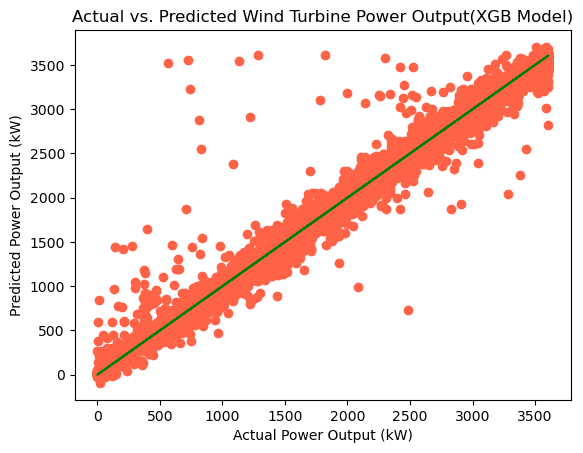

In [14]:
plt.scatter(y_test, y3_pred, color='tomato')

# Adding a line representing perfect predictions (i.e., y_test = y3_pred)
plt.plot(y_test, y_test, color='green')

plt.xlabel("Actual Power Output (kW)")
plt.ylabel("Predicted Power Output (kW)")
plt.title("Actual vs. Predicted Wind Turbine Power Output(XGB Model)")

plt.show()

## Comparison

In [15]:
pd.DataFrame({'Model Accuracy' : [Accuracy_LR , Accuracy_RF, Accuracy_XGB], 'Mean Squared Error' : [y1_mse, y2_mse, y3_mse], 'Mean Absolute Error' : [y1_mae, y2_mae, y3_mae]}, index = ['Multiple Linear Regression', 'Random Forest Regressor', 'XG Boost Regressor'])

,Model Accuracy,Mean Squared Error,Mean Absolute Error
Multiple Linear Regression,85.596673,227817.669889,334.265899
Random Forest Regressor,98.089134,30224.202814,87.232401
XG Boost Regressor,98.772580,19414.116324,67.259051


- In this project, three different models are built to predict the energy generation of wind turbine.
The project consisted in different steps. First, imported the necessary libraries, then loaded and cleaned the data and prepared it for modelling. Then, splitted the data into training and test sets, built the model, and evaluated its performance on the test set using mean squared error and R-squared metrics.
- Here, XGBoost and Random Forest Model is reliable and effective model to predict the output with high accuracy in compare with Multiple Linear Regression model.

## Predict

In [16]:
import pickle

In [17]:
pickle.dump(linear_model,open('linear_model.pkl','wb'))

In [18]:
pickle.dump(forest_model, open('forest_model.pkl','wb'))

In [19]:
pickle.dump(xgb_model, open('xgb_model.pkl','wb'))

In [20]:
detail = [y1_mse, y2_mse, y3_mse,y1_mae, y2_mae, y3_mae]
pickle.dump(detail, open('detail.pkl','wb'))